<a href="https://www.kaggle.com/code/snhippo/brain-tumor-classification-by-mobilenetv2?scriptVersionId=180019922" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### About MobileNetV2 Neural Network Model
* interted residual blocks with bottlenecking features
* MobileNetV1

* Lower parameter count

# IMPORT LIBRARIES


In [287]:
#openCV
import cv2
#mathmetical operation
import numpy as np
#dataframe
import pandas as pd
#tensorflow for google framework of neural network
import tensorflow as tf
#another library for NN which runs on top of tensorflow for more effecient work and functionality
import keras
#directory access
import os
#data visualization 
#module provides tools and utilities for working with images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as k
#sequential model
#enabling the creation and manipulation of Keras models
from tensorflow.keras.models import Model
#model import
from tensorflow.keras.applications import VGG19
#input details
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
#layer and regularization
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
#activation
from tensorflow.keras.optimizers import  SGD, Adam
#tensorboard
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
#model flowchart
from tensorflow.keras.utils import plot_model
#ploting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
#misclassification display
import matplotlib.gridspec as gridspec
from PIL import Image

#Accuracy and Confusion Matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#ROC AUC CURVE
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
from sklearn.preprocessing import label_binarize #for categorical to binary conversion

#Warning
import warnings
from sklearn.exceptions import DataConversionWarning  # Import the specific warning

# Filter specific warnings
warnings.filterwarnings(action='ignore')




# DATA IMPORT AND LOADING

In [288]:
data_dir = ("/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor")
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
valid_dir = os.path.join(data_dir, "Validation")

In [289]:
#Category name based on subclasses directory in dataset
CATEGORIES =["glioma", "meningioma", "notumor", "pituitary"]
NUM_OF_CATEGORIES = len(CATEGORIES)
NUM_OF_CATEGORIES

4

In [290]:
# Data Information

def data_information(sub_data_dir):
    for category in CATEGORIES:
        print('{} {} images'.format(category,len(os.listdir(os.path.join(sub_data_dir, category)))))

In [291]:
print("\n Training Dataset: \n")
data_information(train_dir)
print("\n Testing Dataset: \n")
data_information(test_dir)
print("\n Validation Dataset: \n")
data_information(valid_dir)



 Training Dataset: 

glioma 1321 images
meningioma 1339 images
notumor 1595 images
pituitary 1457 images

 Testing Dataset: 

glioma 300 images
meningioma 306 images
notumor 405 images
pituitary 300 images

 Validation Dataset: 

glioma 175 images
meningioma 139 images
notumor 162 images
pituitary 179 images


# DATA PREPROCESSING

Change data file contents to dataframes

In [292]:
def data_preparation(data, subpath_dir, dataset_dir):
    data_list = []  
    for category_id, category in enumerate(CATEGORIES):
        category_dir = os.path.join(dataset_dir, category)
        
        for file in os.listdir(category_dir):
            data_list.append([f'{data_dir}/{subpath_dir}/{category}/{file}', category_id, category])
    
    data = pd.DataFrame(data_list, columns=['file', 'category_id', 'category'])
    print(f'Shape of {subpath_dir} dataset: {data.shape}')
    return data

**📌note:** It's important to join the data path properly to get valid access of image from directory

In [293]:

train = pd.DataFrame()
trainset = data_preparation(train, 'Training', train_dir)
trainset.head(2)

Shape of Training dataset: (5712, 3)


file  category_id category
0  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma
1  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma

In [294]:
trainset.iloc[0]['file']

'/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Training/glioma/Tr-gl_0954.jpg'

In [295]:
test = pd.DataFrame()
testset = data_preparation(test, 'Testing', test_dir)
testset.head(2)

Shape of Testing dataset: (1311, 3)


file  category_id category
0  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma
1  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma

In [296]:
valid = pd.DataFrame()
validset = data_preparation(valid, 'Validation', valid_dir)
validset.head(2)

Shape of Validation dataset: (655, 3)


file  category_id category
0  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma
1  /kaggle/input/mri-image-based-brain-tumor-clas...            0   glioma

### 🌳 Training Dataset Preprocessing for Randomization

In [297]:
trainset['category'].value_counts()

category
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [298]:
#category sampling
SAMPLE_PER_CATEGORIES = 1321
#reproducability
SEED =42
#image re-sizing
WIDTH = 150
HEIGHT =150
#No of channels
DEPTH = 3

INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

**📌Randomization:** Shuffling the data using `sample(frac=1)` randomizes the order of the samples, reducing the impact of any inherent order or bias in the dataset.

In [299]:
training = trainset.copy()
validing = validset.copy()
testing = testset.copy()

training = pd.concat([training[training['category']==c][:SAMPLE_PER_CATEGORIES] for c in CATEGORIES])

# randomize
training = training.sample(frac=1)
training.index = np.arange(len(training))
training.shape

(5284, 3)

#  EDA (EXPLORATORY DATA ANALYSIS)

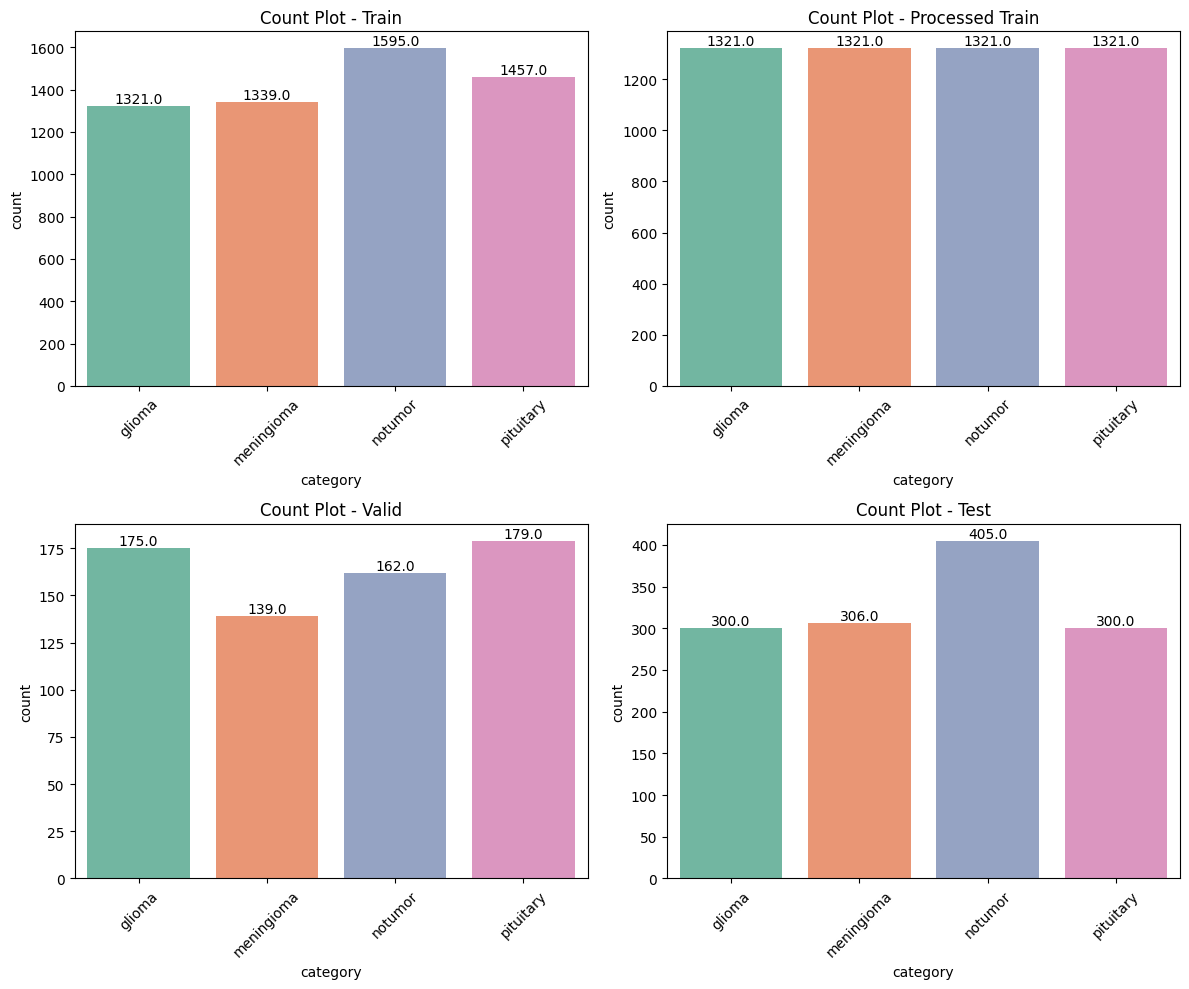

In [303]:

CATEGORIES =["glioma", "meningioma", "notumor", "pituitary"]
# Define a function to create subplots with count plots for different categories
def plot_countplots(train, processed_train, valid, test, categories):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot layout

    datasets = [train, processed_train, valid, test]
    dataset_names = ['Train', 'Processed Train', 'Valid', 'Test']

    for i, ax in enumerate(axes.flatten()):
        sns.countplot(data=datasets[i], x='category', ax=ax, palette= "Set2")
        ax.set_title(f'Count Plot - {dataset_names[i]}')
        ax.set_xticklabels(categories, rotation=45)  # Set category names on x-axis
        
        # Add annotations (counts) on top of each bar
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

plot_countplots(trainset, training, validing, testing, CATEGORIES)


<h2> Image Visualization</h2>


In [304]:
def read_img(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img


**📌About Code:**

`grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05):` Creates a grid layout of subplots (4 rows, 4 columns) within the figure with padding between axes set to 0.05.

`for category_id, category in enumerate(CATEGORIES)::` Loops through each category in the list CATEGORIES using its index (category_id) and value (category).

`for filepath in training[training['category']== category]['file'].values[:NUM_OF_CATEGORIES]::` Loops through a subset of image file paths for the current category (limited by NUM_OF_CATEGORIES) in the training dataset.

`ax = grid[i]:` Gets the current subplot (ax) from the grid using the index i.

`img = read_img(filepath, (WIDTH,HEIGHT)):` Reads and loads the image using a function read_img() (not shown) with specified width and height.

`ax.imshow(img/255.0):` Displays the image on the current subplot (ax) after normalizing pixel values to the range [0,1].

`ax.axis('on'):` Turns on the axes for the subplot.

`if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1::` Checks if the current subplot is the last subplot in a row.

`ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center'):` Adds text to the subplot indicating the category label based on the filepath split.

`i+=1:` Increments the counter variable i to move to the next subplot in the grid.


<h3> Training Image Data </h3>

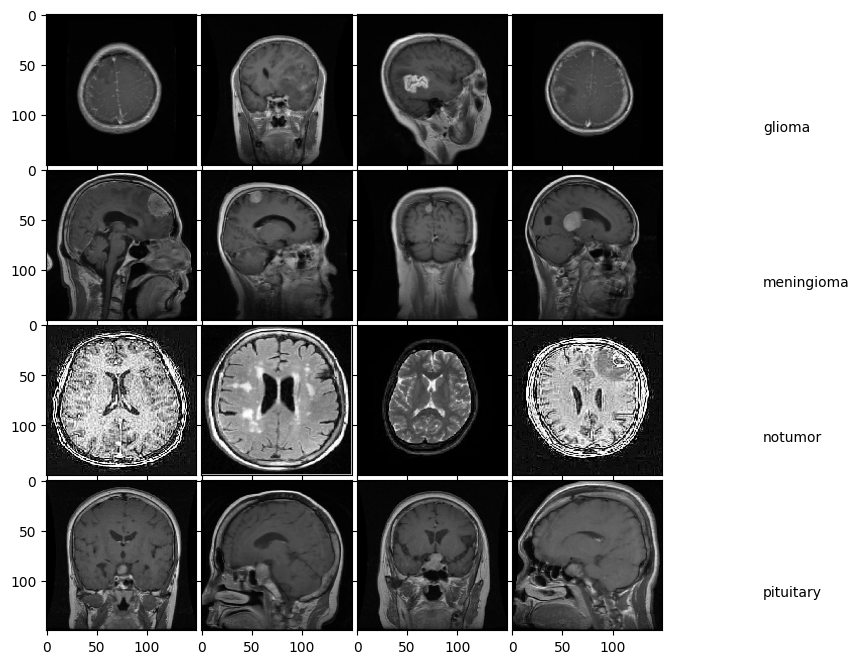

In [392]:

fig = plt.figure(1, figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
i = 0

for category_id, category in enumerate(CATEGORIES):
    for filepath in training[training['category'] == category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.0)
        ax.axis('on')
        if i % NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment='center')
        i += 1

plt.show()

<h3>  Testing Image Data </h3>

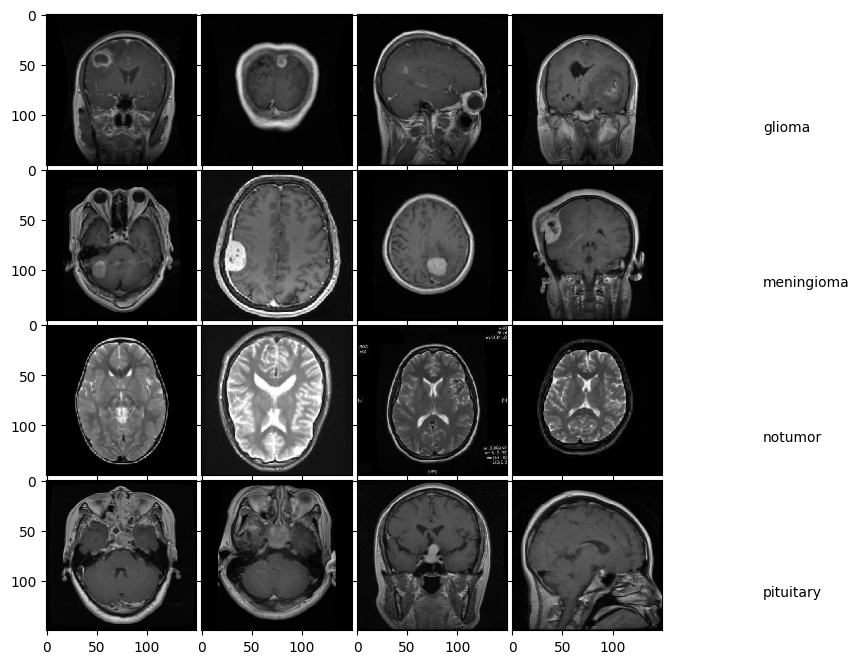

In [306]:
fig = plt.figure(1, figsize=(8,8))
#use of mpl ImageGrid toolkits for visualization
grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05)
i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in testing[testing['category']== category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH,HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('on')
        if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center')
        i+=1
    
plt.show() 

<h3> Validating Image Data </h3>

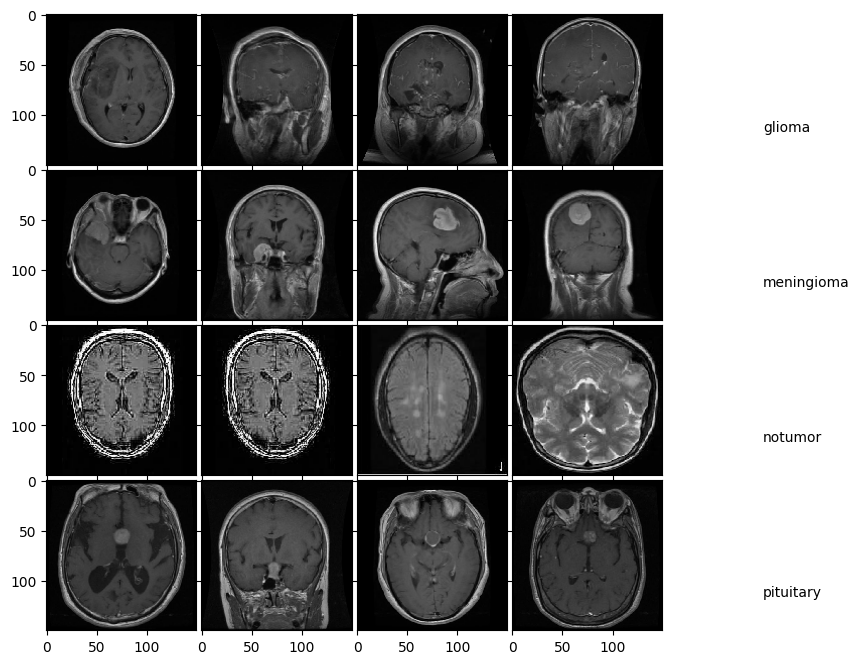

In [307]:
fig = plt.figure(1, figsize=(8,8))
#use of mpl ImageGrid toolkits for visualization
grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05)
i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in validing[validing['category']== category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH,HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('on')
        if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center')
        i+=1
    
plt.show() 

# DATA AUGMENTATION

In [308]:
def prepare_the_datasets(train_dataframe, valid_dataframe, x_columns, y_column, batch_size, image_size):  
    # Define parameters for ImageDataGenerator for train and validation
    train_image_data_generator = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values to [0,1]
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        # Fill in empty pixel after change above          
        fill_mode="nearest"
    )

    val_image_data_generator = ImageDataGenerator(
        rescale=1./255  # Rescale pixel values to [0,1]
    )

    # Create image data generators for train and validation
    train_generator = train_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=train_dataframe,
        shuffle=True,
        x_col=x_columns,
        y_col=y_column,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode='categorical'  # For categorical labels [0,1,0]
    )

    val_generator = val_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=valid_dataframe,
        shuffle=True,
        x_col=x_columns,
        y_col=y_column,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode='categorical'  # For categorical labels
    )
    return train_generator, val_generator

In [309]:
train_dataframe = training
valid_dataframe = testing
x_columns = 'file'
y_column = 'category'
batch_size = 64
image_size = 224

train_data_gen, validation_data_gen = prepare_the_datasets(train_dataframe, valid_dataframe, x_columns, y_column, batch_size, image_size)

Found 5284 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# BUILD MODEL WITH MobileNetV2

In [310]:
from tensorflow.keras.applications import MobileNetV2
Image_size=229,229,3
# pre_trained_model=keras.applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_shape=Image_size)
pre_trained_model= MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=Image_size)

In [311]:
# Freeze the convolutional layers to prevent them from being trained
for layer in pre_trained_model.layers:
    layer.trainable = False

**📌note: Some Basic of Neural Network**

`GlobalAveragePooling2D:` Summarizing the information of each channel with a single value (the average value), resulting in a vector with a size equal to the number of channels

`Dense:` Fully connected layer where each neuron connects to every neuron in the previous layer.

`BatchNormalization:` Normalizes layer inputs, aiding faster training by reducing internal covariate shift.

`Dropout:` During training, randomly deactivates neurons to prevent overfitting.

`Dropout Range:` Typically, dropout rates range between 0.1 to 0.5, where 0.5 means dropping half the neurons during training. Optimal rates vary by dataset and architecture.

In [312]:
# x= pre_trained_model.output
# x= Flatten()(x)
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)

x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)  # Hoặc sử dụng GlobalAveragePooling2D() thay vì Flatten() để giảm chiều
x = Dense(1280, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(640, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Softmax for 4 classes
output = Dense(4, activation='softmax')(x)


In [313]:
custom_model= Model(inputs=pre_trained_model.input, outputs= output)

# MODEL SUMMARY

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 229, 229, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 115, 115, 32)         864       ['input_11[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 115, 115, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 115, 115, 32)         0         ['bn_Conv1[0][0]']     

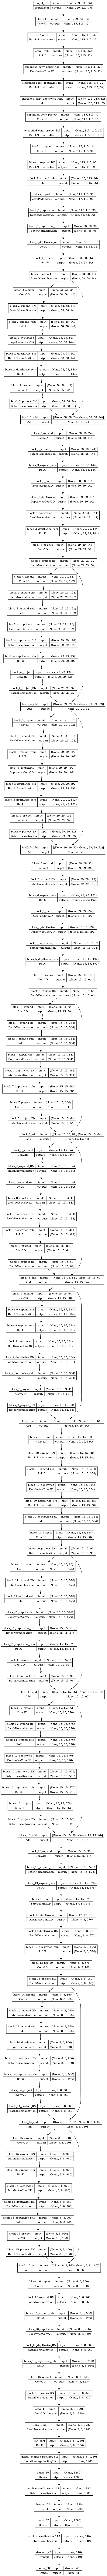

In [347]:
# 16 residual block + fully connected layer
custom_model.summary()
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(custom_model, to_file='model.png', show_shapes=True, show_layer_names=True )

# Display the model architecture image
Image(filename='model.png')

**📌note:** This information shows that the machine learning model has a total of about 147.8 million settings that it learns from the data. Among these, around 147.8 million settings are adjustable during training, taking up about 563.76 megabytes of space. The remaining 6,104 settings, taking up about 23.84 kilobytes, are fixed and not adjusted during training. 

# 🎯 PLOT MODEL

# 🐥 MODEL COMPILE, TENSORBOARD, CHECKPOINT, REDUCE_LR

`Model Compile:` Configuration of a model with loss functions, optimizers, and metrics to prepare it for training.

`TensorBoard:` Visualization tool used to analyze and monitor machine learning models' performance through interactive graphs and summaries.

`Checkpoint:` Saving mechanism that captures the model's weights, allowing resuming training or loading the model for later use.

`Reduce_LR:` Technique to dynamically decrease the learning rate during training to facilitate convergence and prevent overshooting of the optimal solution.

In [322]:
#Compile Model
custom_model.compile(loss='categorical_crossentropy',
               optimizer =tf.keras.optimizers.RMSprop(learning_rate=.0001),
               metrics=["accuracy"])

tensorboard= TensorBoard(log_dir="logs")
checkpoint= ModelCheckpoint("Custom_model_MobileNet_v2.h5",
                           monitor="val_loss",
                           mode="min",
                           save_best_only=True,
                           verbose=1)

early_stopping_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0,
                                                         patience=4,
                                                         verbose=1,
                                                         restore_best_weights=True)

reduce_lr_callback= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        factor=0.3,
                                                        patience=2,
                                                        verbose=1,
                                                        min_delta=0.00001)

CALLBACKS=[tensorboard, early_stopping_callback,checkpoint, reduce_lr_callback]

# MODEL TRAINING

In [323]:
# Calculate steps per epoch and validation steps
#train_steps = len(train_data_gen) // batch_size
#validation_steps = len(validation_data_gen) // batch_size
nb_train_samples=5284 
nb_validation_samples= 1311  
epochs= 24
batch_size= 64
history= custom_model.fit(train_data_gen,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=CALLBACKS,
                   validation_data= validation_data_gen,
                   validation_steps= nb_validation_samples//batch_size,
                   shuffle= True)



Epoch 1/24
82/82 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8287
Epoch 1: val_loss improved from inf to 0.63345, saving model to Custom_model_MobileNet_v2.h5
82/82 [==============================] - 126s 1s/step - loss: 0.4990 - accuracy: 0.8287 - val_loss: 0.6335 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 2/24
82/82 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8439
Epoch 2: val_loss improved from 0.63345 to 0.50847, saving model to Custom_model_MobileNet_v2.h5
82/82 [==============================] - 76s 927ms/step - loss: 0.4437 - accuracy: 0.8439 - val_loss: 0.5085 - val_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 3/24
82/82 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8519
Epoch 3: val_loss did not improve from 0.50847
82/82 [==============================] - 76s 924ms/step - loss: 0.4253 - accuracy: 0.8519 - val_loss: 0.5089 - val_accuracy: 0.8422 - lr: 1.0000e-04
Epoch 4/24
82/82 [==================

# MODEL EVALUATION

In [324]:
train_score= custom_model.evaluate(train_data_gen)
print("\nWe have training loss {:.3f}% and training accuracy {:.3f}% after evaluation."
      .format(train_score[0]*100, train_score[1]*100))

83/83 [==============================] - 72s 861ms/step - loss: 0.2033 - accuracy: 0.9258

We have training loss 20.332% and training accuracy 92.581% after evaluation.


In [325]:
val_score= custom_model.evaluate(validation_data_gen)
print("\nWe have validation loss {:.3f}% and validation accuracy {:.3f}% after evaluation."
      .format(val_score[0]*100, val_score[1]*100))

21/21 [==============================] - 5s 236ms/step - loss: 0.3813 - accuracy: 0.8848

We have validation loss 38.129% and validation accuracy 88.482% after evaluation.


# ACCURACY, LEARNING RATE AND LOSS PLOT

In [326]:
def accuracy_lr_loss_plot():
    fig = plt.figure(figsize=(15,6))
    
    plt.subplot(131)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'go--', label = "val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(132)
    plt.plot(history.history['lr'], 'bo--', label = 'learning Rate')
    plt.title("Learning Rate Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(133)
    plt.plot(history.history['loss'], 'bo--', label = 'loss')
    plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()

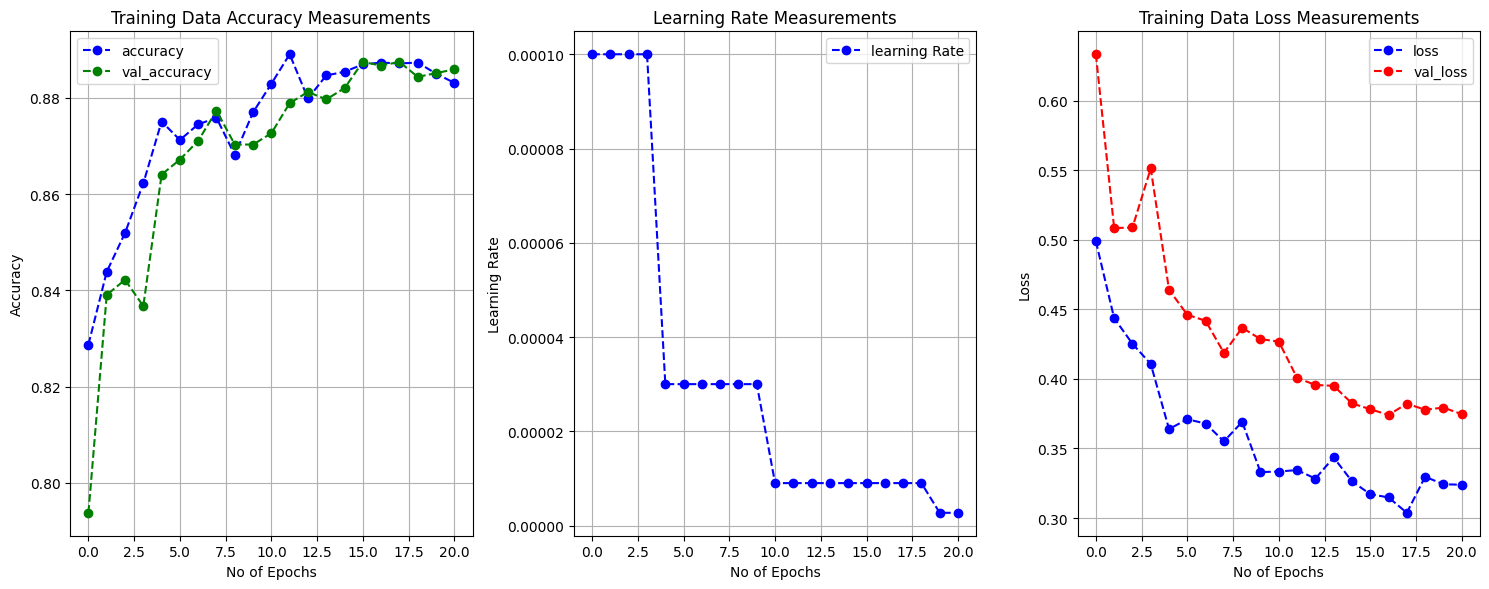

In [327]:
accuracy_lr_loss_plot()


# MODEL PREDICTION WITH TESTING (UNSEEN DATA)

In [357]:
def prepare_test_data(test_dataframe, x_columns, batch_size, image_size):  
    test_image_data_generator = ImageDataGenerator(
        rescale=1./255  # Rescale pixel values to [0,1]
    )
    
    test_generator = test_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=test_dataframe,
        shuffle=False,
        x_col=x_columns,
        y_col=None,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode=None  # For categorical labels
    )
    return test_generator

In [358]:
#testing columns details
testing.columns

Index(['file', 'category_id', 'category'], dtype='object')

In [359]:
#test images preprocessing
test_processed_images = prepare_test_data(validing,'file', 32, 224)

Found 655 validated image filenames.


In [360]:
# Make predictions for images using the model
predictions = custom_model.predict(test_processed_images, steps=len(testing) // 32 + 1)

41/41 [==============================] - 2s 54ms/step


In [361]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 0,
       1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1,
       1, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1,
       3, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1,
       1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3,

In [376]:
#validing dataset to create new dataframe
target_and_predict = validing.copy()
#add column for predicted value
target_and_predict['predicted_classes'] = predicted_classes
#target_and_predict dataframe
target_and_predict

file  category_id  \
0    /kaggle/input/mri-image-based-brain-tumor-clas...            0   
1    /kaggle/input/mri-image-based-brain-tumor-clas...            0   
2    /kaggle/input/mri-image-based-brain-tumor-clas...            0   
3    /kaggle/input/mri-image-based-brain-tumor-clas...            0   
4    /kaggle/input/mri-image-based-brain-tumor-clas...            0   
..                                                 ...          ...   
650  /kaggle/input/mri-image-based-brain-tumor-clas...            3   
651  /kaggle/input/mri-image-based-brain-tumor-clas...            3   
652  /kaggle/input/mri-image-based-brain-tumor-clas...            3   
653  /kaggle/input/mri-image-based-brain-tumor-clas...            3   
654  /kaggle/input/mri-image-based-brain-tumor-clas...            3   

      category  predicted_classes  
0       glioma                  0  
1       glioma                  0  
2       glioma                  0  
3       glioma                  0  
4       glioma                  0  
..         ...                ...  
650  pituitary                  3  
651  pituitary                  3  
652  pituitary                  3  
653  pituitary                  3  
654  pituitary                  3  

[655 rows x 4 columns]

In [377]:
# Calculate accuracy
accuracy = accuracy_score(target_and_predict['category_id'], target_and_predict['predicted_classes'])

print(f"\nWe have test accuracy {accuracy * 100:.4f}% after test images evaluation.")

# Calculate f1_score
from sklearn.metrics import f1_score
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')
print("Training F1 score: {:.3f}".format(f1_train))


We have test accuracy 92.5191% after test images evaluation.
Training F1 score: 0.251


# Image test

1/1 [==============================] - 0s 24ms/step
[[9.9529910e-01 3.0020149e-03 6.8491779e-04 1.0138877e-03]]
Predicted Class: glioma, Probability: 1.00


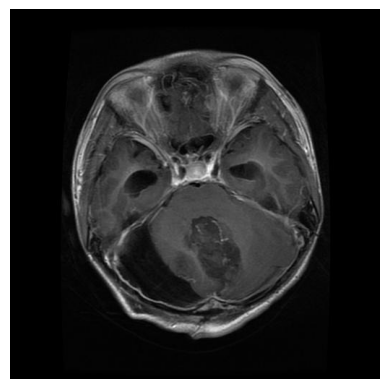

In [365]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the custom model (Assuming it's already loaded, this line is just a placeholder)
# custom_model = load_model('path_to_your_model.h5')

# Define the categories
CATEGORIES = ["glioma", "meningioma", "notumor", "pituitary"]

# Path to the image
image_path = '/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Testing/glioma/Te-glTr_0000.jpg'

# Read and preprocess the image
img = image.load_img(image_path, target_size=(229, 229))  # Adjust the size according to the model's requirement
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch of size 1
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Predict using the model
predictions = custom_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class_name = CATEGORIES[predicted_class_index]
predicted_probability = np.max(predictions)

# Print predictions
print(predictions)
print(f'Predicted Class: {predicted_class_name}, Probability: {predicted_probability:.2f}')

# Display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()

# CONFUSION MATRIX DISPLAY


This code snippet achieves the following:

* Mapping Creation: Constructs a dictionary mapping category IDs to their corresponding names from the DataFrame.
* Replacement: Converts numeric values in 'category_id' and 'predicted_classes' columns to their respective names using the mapping dictionary.
* Report Generation: Utilizes the modified DataFrame to generate a classification report, replacing numeric values with category names, demonstrating the classification performance.

In [387]:
# Replace these with your actual column names
category_id_column = 'category_id'
predicted_classes_column = 'predicted_classes'
category_name_column = 'category'

# Create a mapping dictionary from category_id to category_name
id_to_name_mapping = dict(zip(target_and_predict[category_id_column], target_and_predict[category_name_column]))
print(f"id_to_name_mapping:\n{id_to_name_mapping}")


id_to_name_mapping:
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


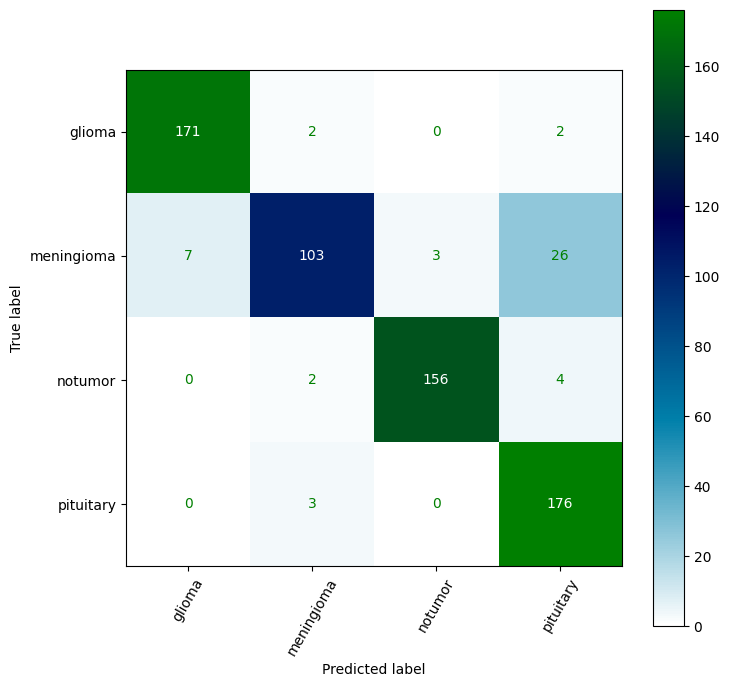

In [386]:
# Generate confusion matrix
conf_matrix = confusion_matrix(
    target_and_predict['category_id'],
    target_and_predict['predicted_classes']
)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(id_to_name_mapping.values()))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='ocean_r',ax=ax,xticks_rotation=60)
plt.show()


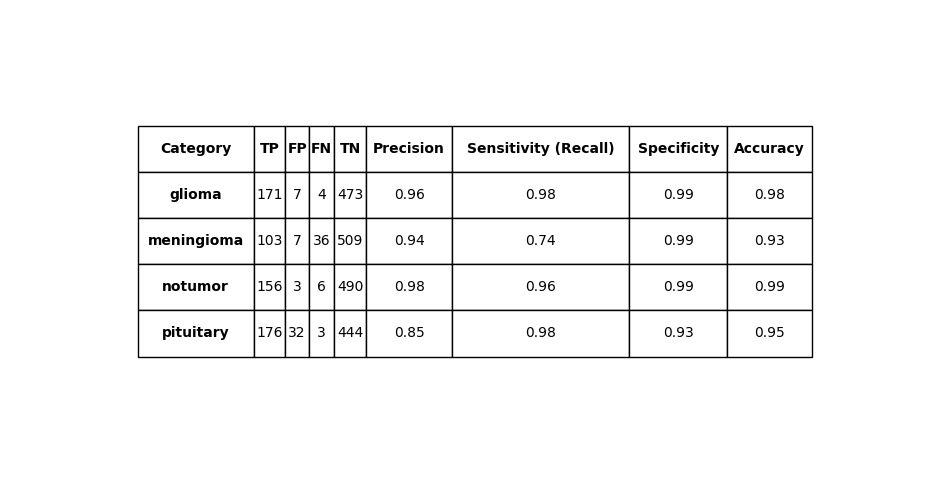

In [388]:
# Calculate and print Precision, Sensitivity, Specificity, and Accuracy for each class
categories = list(id_to_name_mapping.values())
conf_matrix = np.array(conf_matrix)


results = []
for i, category in enumerate(categories):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)
    
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    sensitivity = TP / (TP + FN) if TP + FN != 0 else 0
    specificity = TN / (TN + FP) if TN + FP != 0 else 0
    accuracy = (TP + TN) / conf_matrix.sum() if conf_matrix.sum() != 0 else 0
    
    results.append({
        'Category': category,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 2),
        'Sensitivity (Recall)': round(sensitivity, 2),
        'Specificity': round(specificity, 2),
        'Accuracy': round(accuracy, 2)
    })
results_df = pd.DataFrame(results)

# Display the table
# print(results_df)


# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(12, len(categories) + 2))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')

# Format header
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(fontweight='bold')
    if key[1] == 0:
        cell.set_text_props(fontweight='bold')
    cell.set_height(0.1)  # Increase row height

# Adjust font size and column width
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()

# MISCLASSIFIED IMAGES 

In order to see which image is wrongly classified, so that we can adjust our model

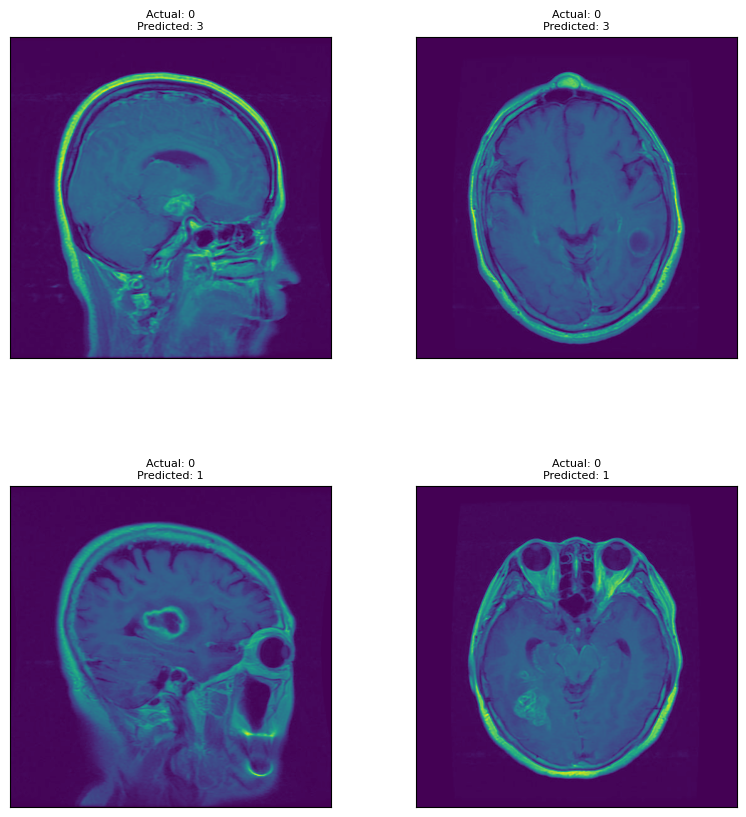

In [390]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image


# Column names
image_path_column = 'file'
category_id_column = 'category_id'
predicted_classes_column = 'predicted_classes'

# Filter misclassified images
misclassified = target_and_predict[target_and_predict[category_id_column] != target_and_predict[predicted_classes_column]]

# num of image
num_images_to_display = 4 
num_images_to_display = min(len(misclassified), num_images_to_display)

# Create Grid
cols = 2  
rows = (num_images_to_display + cols - 1) // cols 

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(rows, cols)
gs.update(wspace=0.1, hspace=0.4)

for i, (_, row) in enumerate(misclassified.head(num_images_to_display).iterrows()):
    img_path = row[image_path_column]
    actual_label = row[category_id_column]
    predicted_label = row[predicted_classes_column]

    img = Image.open(img_path)
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}', fontsize=8)

plt.tight_layout()
plt.show()

# Save and Load Model

In [383]:
import pickle

# Save history using pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [384]:
import pickle

# Load history using pickle
with open('/kaggle/input/history/history.pkl', 'rb') as file:
    history.history = pickle.load(file)

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/kaggle/input/mobilenetv2-24/Custom_model_MobileNetV2_24.h5'

custom_model = load_model(model_path)

